In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import toolz as f

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

# Conformal Inferece for Synthetic Controls

## Synthetic Control Refresher

Synthetic Control (SC) is a particularly usefull causal inference tecnique for when you have a single treatment unit and very few control units, but you have repeted observation each unit through time (although there are plety of SC extentions in the Big Data workd). The canonical use case is when you want to know the impact the treatment in one geography (like a state) and you use the other, untreated states as controls. In our Synthetic Control chapter, we've motivated the technique by trying to estimate the effect of Proposition 99 (a bill passed in 1988 that increased cigaret tax in California) in cigarete sales. 

In order to do that, we have to estimate what would have happened to California, had it not passed Proposition 99. This ammounts to estimating the counterfactual $Y_{t}(0)$ so that we can contract it to the observed outcome in the post intervention periods:

$$
ATT = Y_{t}(1) - Y_{t}(0) = Y_{t} - Y_{t}(0)  \text{ for } t \geq 1988
$$

There are many methods to do that, among which, we have Synthetic Controls. Synthetic Controls tries to combine the control units to mimic the pre-treatment trend of the treated unit. In our case, this means finding a combination of states that mimic the California trend for cigarette sales prior to Proposition 99. We have to find this combination becase it is rarely the case that a single control unit can mimic the trend of the treated unit. We can see that by ploting the cigarette sales trends for all states ans hilightinh California. Notice how there aren't any single blue line (control state) that follows a path similar to that of California.

In [2]:
data = pd.read_csv("data/smoking.csv")

data = data.pivot("year", "state", "cigsale")
data = data.rename(columns={c: f"state_{c}" for c in data.columns}).rename(columns={"state_3": "california"})
data.shape

(31, 39)

Text(0, 0.5, 'Cigarette Sales')

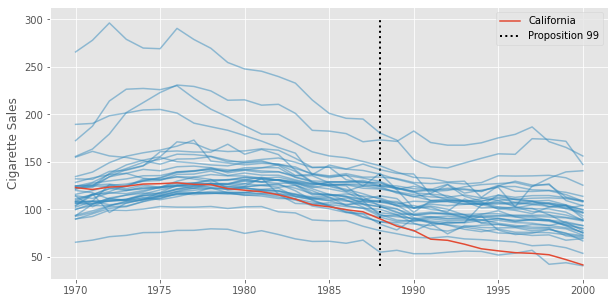

In [3]:
plt.figure(figsize=(10,5))
plt.plot(data.drop(columns=["california"]), color="C1", alpha=0.5)
plt.plot(data["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")

In order to find the combination of states that better approximate the pre-treatment trend of Califorina, Synthetic Control runs a horizontal regression, where the rows are the time periods and the columns are the states. It tries to find the weights that, when multiplied by the control states, better aproximate the treated state

![img](data/img/synth-control/regr_space.png)

Since we have more states (39, some where discared from the analysis) than time periods, an unconstrained regression would simply overfitt, which is why Synthetic Control imposes two restrictions.

1. Weights must sum to 1
2. Weights be non-negative

Or, in mathematical terms, let $\pmb{y}$ be the vector of outcomes for the treated state in the pre-treated periods, $\pmb{X}$ the $J$ by $T0$ matrix, where each column is a state $j$ and each row is a period $t$ prior to the intervention period $T1 = T0 + 1$

$$
\underset{w}{\mathrm{argmin}} \ ||\pmb{y} - \pmb{X} \pmb{w}|| \\
\text{s.t } \ \sum w_j = 1 \text{ and } \ w_j > 0 \ \forall \ j
$$

Combined, this constraints means we are defining the synthetic control as a convex combination of the control units. It also means we are not doing any dangerous extrapolation and that our synthetic control will use only a small subset of control units. 

![img](data/img/synth-control/extrapolation.png)

Here is what this looks like in code, as a Sklearn estimator:

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)
    
        
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X @ w-y))
        
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        self.X_ = X
        self.y_ = y
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)
        
        
        return X @ self.w_

Now, let's apply this method to our data, fiting it in the pre-intervention period (prior to 1988).

In [5]:
model = SyntheticControl()

train = data[data.index < 1988]

model.fit(train.drop(columns=["california"]), train["california"]);


Finally, we can plot side by sinde the trend for California and for the Synthetic Control. The difference between these two lines is the estimated effect of Proposition 99 in Califorina

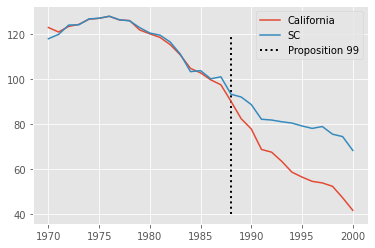

In [6]:
plt.plot(data["california"], label="California")
plt.plot(data["california"].index, model.predict(data.drop(columns=["california"])), label="SC")
plt.vlines(x=1988, ymin=40, ymax=120, linestyle=":", lw=2, label="Proposition 99", color="black")

plt.legend();

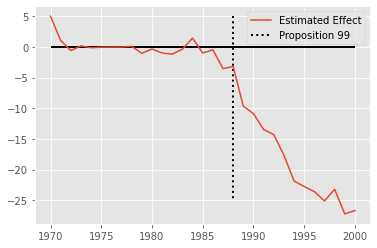

In [7]:
pred_data = data.assign(**{"residuals": data["california"] - model.predict(data.drop(columns=["california"]))})

plt.plot(pred_data["california"].index, pred_data["residuals"], label="Estimated Effect")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=5, ymax=-25, linestyle=":", lw=2, label="Proposition 99", color="Black")

plt.legend();

## Inference for Grown Ups

In the Synthetic Control chapter, we showed a inference procedure where we permutated units, pretending control units where treated. If the post-treatment difference (error) between the synthetic control and the unit was too extreame for the treated unit, we would conclude that the effect we are seeing is not due to chance. 

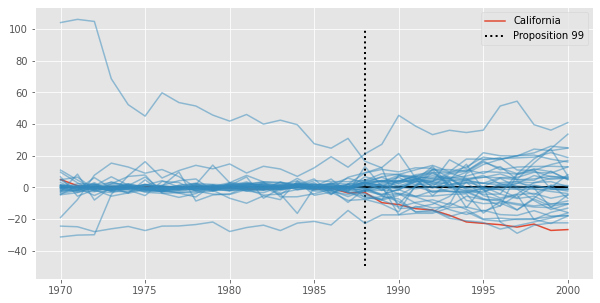

In [8]:
plt.figure(figsize=(10,5))
for state in data.columns:
    
    model_ier = SyntheticControl()
    train_iter = data[data.index < 1988]
    model_ier.fit(train_iter.drop(columns=[state]), train_iter[state])
    
    effect = data[state] - model_ier.predict(data.drop(columns=[state]))
    
    is_california = state == "california"
    
    plt.plot(effect,
             color="C0" if is_california else "C1",
             alpha=1 if is_california else 0.5,
             label="California" if is_california else None)

plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=-50, ymax=100, linestyle=":", lw=2, label="Proposition 99", color="Black")
plt.legend();

In this case, we can see that the post-treatment difference for california is quite extreme, when compared to the other states. However, there are also some states with terrible pre-treatment fit, which than translates to a huge error in the post-intervention period. The guideline here is to remove units with high pre-treatment error, but how high is a bit more complicated. Not only that, this procedure assumes a random assignment of the intervention, which is hard to believe for this kind of policy intervention (see Abadie, 2021)

One alternative method for inference is to recast the problem of effect estimation as counterfactual prediction. If you think about it, we are tryin to predict the counterfactual $Y_{i, t}(0)$ where $i$ is the treated unit and $t \geq T1$, the start of the intervention. If we do that, we can leverage the literature on **Conformal Prediction for inference**. Interestingly enought, this method is quite general and applies to other models of $Y_{i, t}(0)$, besides Synthetic Controls. To understand this procedure, let's first look at how we would do Hypothesis Tests and get P-Values.

### Hypothesis Test and P-Values

Let's say we are interested in thesting the Hypothesis about the trajectory of effects in the post treatment period $\theta = (\theta_{T0+1}, ..., \theta_{T})$

$$
H_0 : \theta = \theta^0
$$

For instance, if we wish to test for no effect whatsoever, we can set $\theta_0 = (0, ..., 0)$. Notice that this hypothesis fully determines the counterfactual outcome in the absence of treatment 

$$
Y_t(0) = Y_t(1) - \theta_t = Y_t - \theta_t
$$

The key idea is to then generate data folowing the null hypothesis we want to test and check the residuals of a model for $Y(0)$ in this generated data. If the residuals are too extreme, we say that the data is unlikly to have come from the null hypothesis we've postulated. If this whole procedure sounds obscure at first, don't wory, it will become clear as we walk through a step by step implementation of it. 

The first step is to generate data under the null hypothesis. This is achieved by simply subtracting the postulated null from the outcome of the treated unit, just like in equation above. Here is the code to do that.

In [9]:
def with_effect(df, state, null_hypothesis, start_at, window):
    window_mask = (df.index >= start_at) & (df.index < (start_at +window))
    
    y = np.where(window_mask, df[state] - null_hypothesis, df[state])
    
    return df.assign(**{state: y})

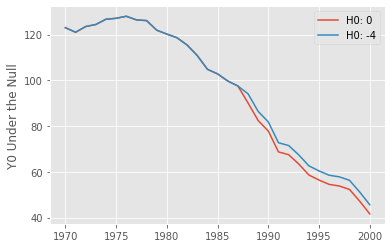

In [10]:
plt.plot(with_effect(data, "california", 0, 1988, 2000-1988+1)["california"], label="H0: 0")
plt.plot(with_effect(data, "california", -4, 1988, 2000-1988+1)["california"], label="H0: -4")

plt.ylabel("Y0 Under the Null")
plt.legend();

If we postulate the null of no effect, the data under that null means that $Y(0) = Y(1) = Y$, which is just the trajectory of observed outcome we see for the treated state of California. Now, if we postulate that the null is -4, that is, Proposition 99 decreases cigarette sales by 4 packs, then $Y(0) = Y(1) - (-4)$, which shifts the trajectory of the post treatment outcomes by 4. This is very intuitive. If we think the bill decreases cigarrete sales, then, in the absense of it, we should see higher levels of cigarrete sales than the one we have in our observed data. 

The next part of the inference procedure is to fit a model for the counterfactual $Y(0)$ (which we get with the function we just created) in the entire data, pre **and** post-treatment period. This is an important distinction between how we usually fit synthetic controls. The idea here is that the model must be estimated with the entire data, under the postulated null hypothesis, to avoid huge post intervention residuals. With this model, we then compute the residuals $\hat{u_t} = Y_t - \hat{Y}_t(0)$ for all time periods $t$.

The function to do that first uses the `with_effect` function we created to generate data under then null. Then, it fits the model in this data under the null. It then estimates $Y(0)$ by making predictions with the recenlty fit model. Finally, it computes the residuals $\hat{u}_t$ and stores everything in a dataframe

In [11]:
@curry
def residuals(df, state, null, intervention_start, window, model):
    
    null_data = with_effect(df, state, null, intervention_start, window)
            
    model.fit(null_data.drop(columns=[state]), null_data[state])
    
    y0_est = pd.Series(model.predict(null_data.drop(columns=[state])), index=null_data.index)
    
    residuals = null_data[state] - y0_est
    
    test_mask = (null_data.index >= intervention_start) & (null_data.index < (intervention_start + window))
    
    return pd.DataFrame({
        "y0": null_data[state],
        "y0_est": y0_est,
        "residuals": residuals,
        "post_intervention": test_mask
    })[lambda d: d.index < (intervention_start + window)]  # just discard  points after the defined effect window

With our data, to get the residuals for $H_0 : 0$, meaning Proposition 99 had no effect, we can simply pass 0 as the null for our function. 

In [12]:
residuals_df = SyntheticControl()

residuals_df = residuals(data,
                         "california",
                         null=0.0,
                         intervention_start=1988,
                         window=2000-1988+1,
                         model=model)

residuals_df.head()

,y0,y0_est,residuals,post_intervention
year,,,,
1970,123.000000,112.529475,10.470525,False
1971,121.000000,114.315723,6.684277,False
1972,123.500000,119.302289,4.197711,False
1973,124.400002,121.265554,3.134447,False
1974,126.699997,124.356696,2.343301,False


The result is a dataframe containing the estimated residuals for each time period, something we will use going foreward. Remember that the idea here is to see if that residual, in the post intervention period, is too high. If it is, the data is unlikly to have come from this null where the effect is zero. To get a visual idea of what we are talking about, we can inspect the error of our model in the post intervention period.

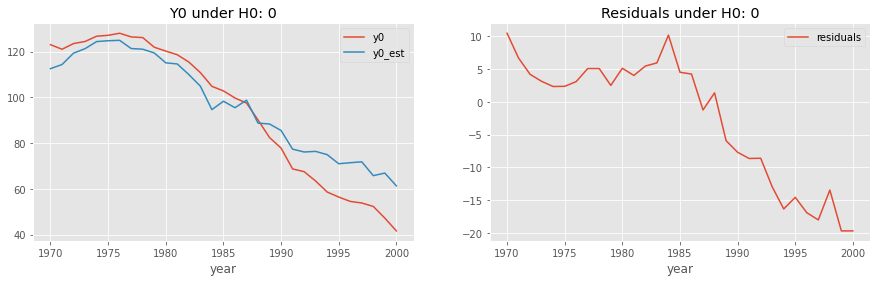

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
residuals_df[["y0", "y0_est"]].plot(ax=ax1)
ax1.set_title("Y0 under H0: 0");
residuals_df[["residuals"]].plot(ax=ax2);
ax2.set_title("Residuals under H0: 0");

We can already see that the model fitted under $H_0: 0$ yields quite large and negative residuals, wich is some evidence we might want to reject this null of no effect. 

#### Test Statistic

This visual evidence is interesting for our own understanding, but we need to be a bit more precise here. This is done by the definition of a **Test Statistic S**, which summaries how extreme are the residuals and hence, how unikly is the data we saw, under the null. 

$$
S(\hat{u})_q = \bigg(\sum_{t=T0 + 1}^{T} |u_t|^q \bigg) ^{1/q}
$$

Here, we focus on $q=1$, which gives us $S(\hat{u}) = \sum_{t=T0 + 1}^{T} |u_t|$.

Notice tha this statistic is computed using only the post-intervention period, with $t \geq T0 + 1$. So, although we use all the data to fit our model for the counterfactual $Y(0)$, we check the residuals only for the outcome which concerns the formulate null hypothesis, that is, the post-intervention period. 

In [14]:
def test_statistic(u_hat, q=1, axis=0):
    return (np.abs(u_hat) ** q).mean(axis=axis) ** (1/q)

In [15]:
print("H0:0 ", test_statistic(residuals_df.query("post_intervention")["residuals"]))

H0:0  12.602929955114083


High values of this test statistic indicate poor post intervention fit and, hence rejection of the null. However, we could have pretty big test statistic in the post-intervention period if our model is poorly fitted, even if $H_0$ is true. This means we can't define high in absolute terms. Rather, we have to think about how high are the post intervention residuals and test statistic in comparisson to the pre-intervention residuals. 

#### P-Value

To compute the P-value, we block-permutate the residuals, calculating the test statistic each time. This procedure is better understood by the folowing picture

![img](data/img/sc-conformal-inf/block-perm.png)

Once we do that, we will end up with $T$ test statistics, one for each of the block permutation.

Let $\Pi$ be the set of all block permutations, by the definition of p-value 

$$
\text{P-value} = \frac{1}{|\Pi|}\sum_{\pi \in \Pi} \mathcal{1}\{S(\hat{u}_{\pi_0}) \leq S(\hat{u}_{\pi})\}
$$

and $\hat{u}_{\pi_0}$ is the original (unpermuted) vector or residuals. In plain terms, we are simply finding the proportion of times that the unpermutes test statistic is higher (more extreme) than the test statistics obtained by all possible block permutations. 

To implement this, we will make use of the `np.roll` function, which takes an array and cicles it much like we've represented in the image above.

In [16]:
def p_value(resid_df, q=1):
    
    u = resid_df["residuals"].values
    post_intervention = resid_df["post_intervention"].values
    
    block_permutations = np.stack([np.roll(u, permutation, axis=0)[post_intervention]
                                   for permutation in range(len(u))])
    
    statistics = test_statistic(block_permutations, q=1, axis=1)
    
    p_val = np.mean(statistics >= statistics[0])

    return p_val

We can now compute the P-value for $H_0: 0$. As we can't see, it is a low P-value, but not extremely low. At $\alpha=0.05$, we would not reject this null. 

In [17]:
p_value(residuals_df)

0.16129032258064516

Remember, this is the P-value for the null hypothesis which states that the effect in all time periods is zero: $\theta = (\theta_{T0+1}=0, ..., \theta_{T}=0)$. From our effect plot from the Synthetic Control, we get the feeling that the effect of Propostion 99 start small, around -5, but gradually increases to -25. For this reason, it might be interesting to plot the confidence intervall for effect each post treatment period individually, rather than test a null hypothesis about an entire effect trajecotry.

### Confidence Intervals

In [18]:
def p_val_grid(df, state, nulls, intervention_start, period, model):
    
    df_aug = df[df.index < intervention_start].append(df.loc[period])
    
    p_vals =  {null: p_value(residuals(df_aug,
                                       state,
                                       null=null,
                                       intervention_start=period,
                                       window=1,
                                       model=model)) for null in nulls}        
        
    return pd.DataFrame(p_vals, index=[period]).T

In [19]:
model = SyntheticControl()

nulls = np.linspace(-20, 20, 100)

p_values_df = p_val_grid(
    data,
    "california",
    nulls=nulls,
    intervention_start=1988,
    period=1988,
    model=model
)

In [20]:
p_values_df.head()

,1988
-20.000000,0.052632
-19.595960,0.052632
-19.191919,0.052632
-18.787879,0.052632
-18.383838,0.052632


In [21]:
def confidence_interval_from_p_values(p_values, alpha=0.1):
    big_p_values = p_values[p_values.values >= alpha]
    return pd.DataFrame({
        f"{int(100-alpha*100)}_ci_lower": big_p_values.index.min(),
        f"{int(100-alpha*100)}_ci_upper": big_p_values.index.max(),
    }, index=[p_values.columns[0]])

In [22]:
confidence_interval_from_p_values(p_values_df)

,90_ci_lower,90_ci_upper
1988,-12.323232,8.686869


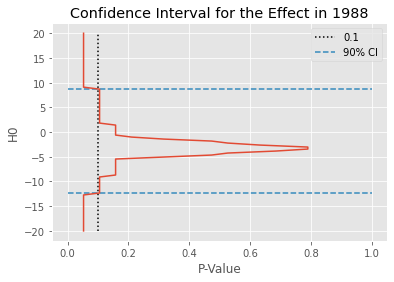

In [23]:
plt.plot(p_values_df[1988], p_values_df.index)
plt.xlabel("P-Value")
plt.ylabel("H0")
plt.vlines(0.1, nulls.min(), nulls.max(), color="black", ls="dotted", label="0.1")

plt.hlines(confidence_interval_from_p_values(p_values_df)["90_ci_upper"], 0, 1, color="C1", ls="dashed")
plt.hlines(confidence_interval_from_p_values(p_values_df)["90_ci_lower"], 0, 1, color="C1", ls="dashed", label="90% CI")

plt.legend()
plt.title("Confidence Interval for the Effect in 1988");

In [24]:
def compute_ci(df, state, nulls, intervention_start, period, model, alpha=0.1):
    p_vals = p_val_grid(df=df,
                        state=state,
                        nulls=nulls,
                        intervention_start=intervention_start,
                        period=period,
                        model=model)
    
    return confidence_interval_from_p_values(p_vals, alpha=alpha)


def confidence_interval(df, state, nulls, intervention_start, window, model, alpha=0.1, jobs=4):    
    return pd.concat([compute_ci(df, state, nulls, intervention_start, period, model, alpha)
                     for period in range(intervention_start, intervention_start+window)])

In [25]:
model = SyntheticControl()

nulls = np.linspace(-60, 20, 100)

ci_df = confidence_interval(
    data,
    "california",
    nulls=nulls,
    intervention_start=1988,
    window=2000 - 1988 + 1,
    model=model
)

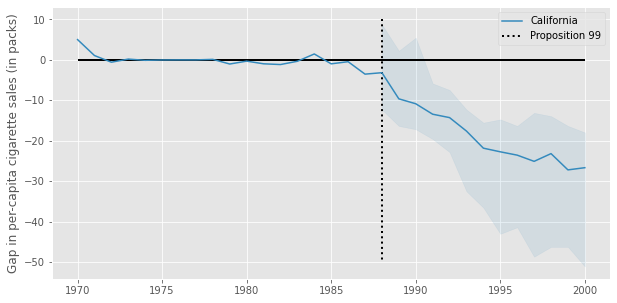

In [27]:
plt.figure(figsize=(10,5))
plt.fill_between(ci_df.index, ci_df["90_ci_lower"], ci_df["90_ci_upper"], alpha=0.1,  color="C1")
plt.plot(pred_data["california"].index, pred_data["residuals"], label="California", color="C1")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=10, ymax=-50, linestyle=":", color="Black", lw=2, label="Proposition 99")
plt.legend()
plt.ylabel("Gap in per-capita cigarette sales (in packs)");